In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [146]:
# Load useful libraries
import numpy as np
import pandas as pd
import os
import tqdm
import pathlib
import time
import pickle
import seaborn as sns
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler

# Plotting libraries
from matplotlib import pyplot as plt
%matplotlib inline

In [35]:
DATA_DIR="../datasets/"

MWRA_DATA_DIR=os.path.join(DATA_DIR, "mwra")
MWRA_DATA_FILE=os.path.join(MWRA_DATA_DIR, "data-20210424.csv")

MASS_COVID_DATA_DIR=os.path.join(DATA_DIR, "mass-covid")
MASS_COVID_DATA_FILE=os.path.join(MASS_COVID_DATA_DIR, "covid-19-raw-data-4-27-2021.xlsx")

In [118]:
# Load MWRA dataset
df_mwra = pd.read_csv(MWRA_DATA_FILE, parse_dates=['Date'])
display(df_mwra.tail(5))
df_mwra.fillna(0, inplace=True)

,Date,Southern (copies/mL),Northern (copies/mL),Southern 7 day avg,Northern 7 day avg,Southern Low Confidence Interval,Southern High Confidence Interval,Northern Low Confidence Interval,Northern High Confidence Interval
414,2021-04-19,177,181.0,266.0,214,56,82,57,83
415,2021-04-20,198,131.0,257.0,207,62,91,41,61
416,2021-04-21,203,158.0,237.0,194,64,94,50,73
417,2021-04-22,355,108.0,239.0,174,112,164,34,50
418,2021-04-23,192,80.0,231.0,155,61,89,25,37


In [45]:
df_mwra.columns

Index(['Date', 'Southern (copies/mL)', 'Northern (copies/mL)',
       'Southern 7 day avg', 'Northern 7 day avg',
       'Southern Low Confidence Interval', 'Southern High Confidence Interval',
       'Northern Low Confidence Interval',
       'Northern High Confidence Interval'],
      dtype='object')

In [46]:
# Describe the dataset
df_mwra.describe()

,Southern (copies/mL),Northern (copies/mL),Southern 7 day avg,Northern 7 day avg,Southern Low Confidence Interval,Southern High Confidence Interval,Northern Low Confidence Interval,Northern High Confidence Interval
count,419.000000,417.000000,418.000000,419.000000,419.000000,419.000000,419.000000,419.000000
mean,273.649165,238.755396,271.846890,256.248210,86.486874,126.448687,75.109785,109.751790
std,395.912674,316.521194,318.712737,280.483717,125.104135,182.915802,99.923212,146.059945
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,21.000000,38.000000,47.500000,5.000000,7.500000,6.500000,9.500000
50%,97.000000,103.000000,134.000000,165.000000,31.000000,45.000000,32.000000,46.000000
75%,381.000000,318.000000,377.500000,336.000000,120.500000,176.500000,100.500000,146.500000
max,3772.000000,1451.000000,1476.000000,1130.000000,1192.000000,1743.000000,458.000000,670.000000


Text(0.5, 1.05, 'Relationship plot between Southern and Northern Viral Titers')

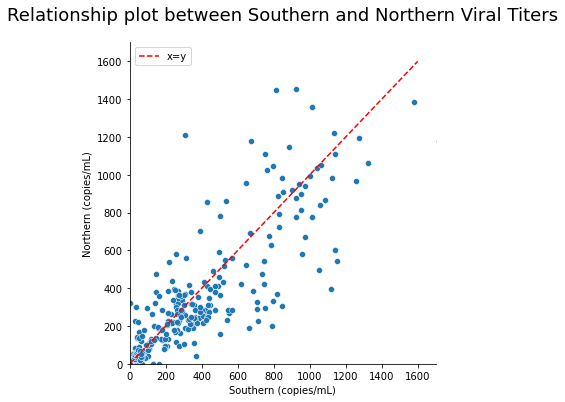

In [133]:
# Show the relation between norther and souther samples
sns.relplot(data=df_mwra, x="Southern (copies/mL)", y="Northern (copies/mL)")
plt.plot([0,1600], [0,1600], '--r', label="x=y")
plt.xlim([0, 1700])
plt.ylim([0, 1700])
plt.legend()
plt.title('Relationship plot between Southern and Northern Viral Titers', fontsize=18, y=1.05)

<ipython-input-130-aca315f587b7>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


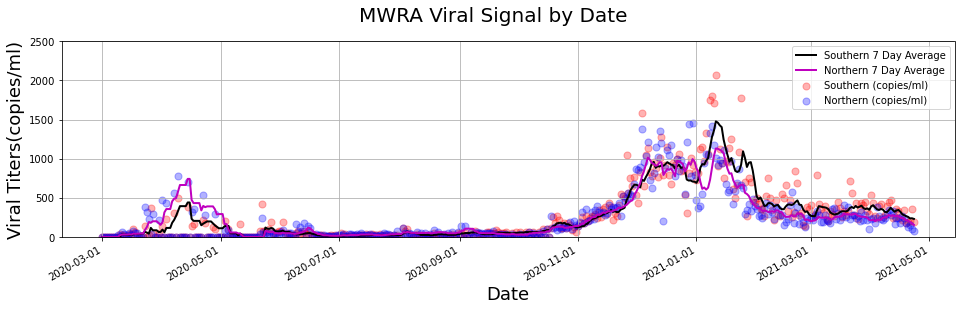

In [130]:
# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.scatter(df_mwra['Date'], df_mwra['Southern (copies/mL)'], color='r', s = 50, alpha=0.3, label="Southern (copies/ml)")
ax.scatter(df_mwra['Date'], df_mwra['Northern (copies/mL)'], color='b', s = 50, alpha=0.3, label="Northern (copies/ml)")
ax.plot(df_mwra['Date'], df_mwra['Southern 7 day avg'], 'k', linewidth = 2,  label="Southern 7 Day Average")
ax.plot(df_mwra['Date'], df_mwra['Northern 7 day avg'], 'm', linewidth = 2, label="Northern 7 Day Average")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 2500])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Viral Titers(copies/ml)', fontsize=18)

fig.autofmt_xdate()
fig.suptitle('MWRA Viral Signal by Date', fontsize=20, y=1.00)
fig.show()

In [77]:
# Load MWRA dataset
df_covid= pd.read_excel(MASS_COVID_DATA_FILE,sheet_name='County_Daily', parse_dates=['Date'])
display(df_covid.tail(5))

,Date,County,New Confirmed Cases,Total Confirmed Cases,New Probable and Confirmed Deaths,Total Probable and Confirmed Deaths
3947,2021-04-27,Plymouth,102.0,47504.0,0.0,1407.0
3948,2021-04-27,Suffolk,92.0,90448.0,1.0,1813.0
3949,2021-04-27,Worcester,91.0,74867.0,0.0,2187.0
3950,2021-04-27,Unknown,-7.0,1135.0,0.0,7.0
3951,2021-04-27,Dukes and Nantucket,NaN,NaN,0.0,5.0


In [79]:
# Describe the dataset
df_covid.describe()

,New Confirmed Cases,Total Confirmed Cases,New Probable and Confirmed Deaths,Total Probable and Confirmed Deaths
count,3703.000000,3705.000000,3458.000000,3463.000000
mean,142.525520,23064.031309,2.525448,907.071325
std,210.905112,28579.463135,3.385478,845.637645
min,-69.000000,34.000000,-1.000000,0.000000
25%,8.000000,1317.000000,0.000000,116.500000
50%,52.000000,9980.000000,1.000000,834.000000
75%,191.000000,37957.000000,4.000000,1396.000000
max,1607.000000,131487.000000,24.000000,3713.000000


<ipython-input-129-5582d326b7aa>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


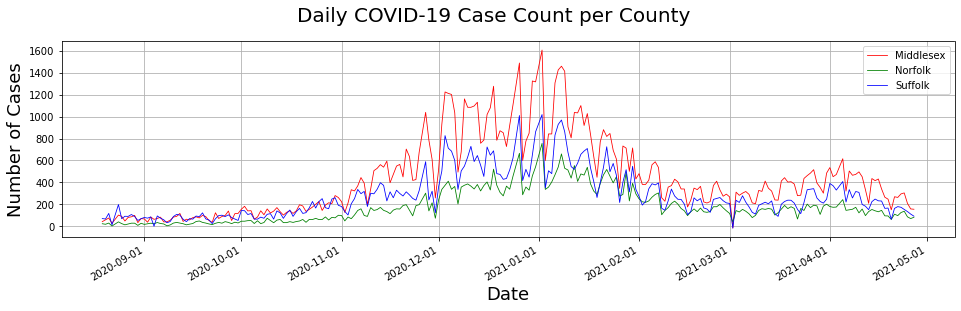

In [129]:
# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

df_ms = df_covid[df_covid['County'].str.contains("Middlesex", case = False)]
df_nr = df_covid[df_covid['County'].str.contains("Norfolk", case = False)]
df_sf = df_covid[df_covid['County'].str.contains("Suffolk", case = False)]

# Plot southern samples
ax.plot(df_ms['Date'], df_ms['New Confirmed Cases'], 'r', linewidth = 0.8, label="Middlesex")
ax.plot(df_ms['Date'], df_nr['New Confirmed Cases'], 'g', linewidth = 0.8, label="Norfolk")
ax.plot(df_ms['Date'], df_sf['New Confirmed Cases'], 'b', linewidth = 0.8, label="Suffolk")


ax.grid(True)
ax.legend()
#ax.set_ylim([0, 2500])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Number of Cases', fontsize=18)


fig.autofmt_xdate()
fig.suptitle('Daily COVID-19 Case Count per County', fontsize=20, y=1.00)
fig.show()

In [106]:
df_combined = pd.DataFrame(data=None, columns=['Date', 'New Confirmed Cases'])

allDates = df_covid['Date'].unique()

for i, i_date in enumerate(allDates):
    total = 0
    
    # Add middlesex cases
    row = df_ms[df_ms['Date'] == i_date]
    if not row.empty:
        total += row['New Confirmed Cases'].to_list()[0]
        
    # Add norfolk cases
    row = df_nr[df_nr['Date'] == i_date]
    if not row.empty:
        total += row['New Confirmed Cases'].to_list()[0]
        
    # Add norfolk cases
    row = df_sf[df_sf['Date'] == i_date]
    if not row.empty:
        total += row['New Confirmed Cases'].to_list()[0]
        
    df_combined.at[i, 'Date'] = pd.to_datetime(i_date, format='%Y-%m-%d')
    df_combined.at[i, 'New Confirmed Cases'] = total

display(df_combined)

,Date,New Confirmed Cases
0,2020-08-19 00:00:00,135.0
1,2020-08-20 00:00:00,142.0
2,2020-08-21 00:00:00,221.0
3,2020-08-22 00:00:00,41.0
4,2020-08-24 00:00:00,340.0
...,...,...
242,2021-04-23 00:00:00,593.0
243,2021-04-24 00:00:00,595.0
244,2021-04-25 00:00:00,429.0
245,2021-04-26 00:00:00,339.0


<ipython-input-123-d3df2ab08445>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


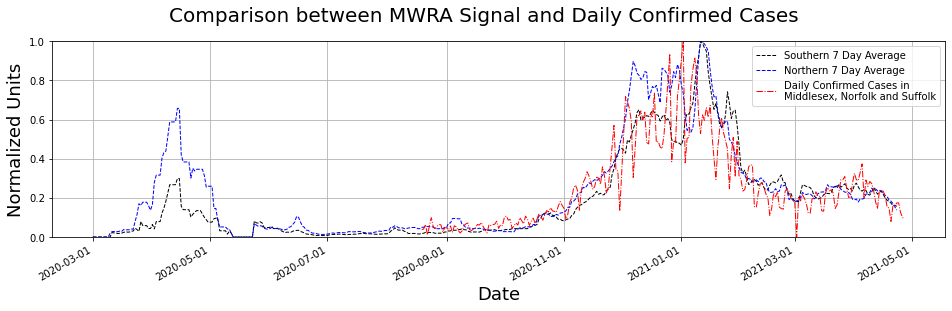

In [123]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_mwra['Date'], normalize(df_mwra['Southern 7 day avg'].to_numpy()), '--k', linewidth = 1,  label="Southern 7 Day Average")
ax.plot(df_mwra['Date'], normalize(df_mwra['Northern 7 day avg'].to_numpy()), '--b', linewidth = 1, label="Northern 7 Day Average")
ax.plot(df_combined['Date'], normalize(df_combined['New Confirmed Cases'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

In [148]:
# Create algined matrix between southern, northen and covid cases
df_aligned = pd.DataFrame(data=None, columns=['Date', 'Southern', 'Northern','New Confirmed Cases'])

covidDates = df_covid['Date'].unique()
mwraDates = df_mwra['Date'].unique()
commonDates = np.intersect1d(covidDates, mwraDates)

for i, i_date in enumerate(commonDates):
    total = 0
    
    row = df_mwra[df_mwra['Date'] == i_date]
    if not row.empty:
        df_aligned.at[i, 'Southern'] = row['Southern 7 day avg'].to_list()[0]
        df_aligned.at[i, 'Northern'] = row['Northern 7 day avg'].to_list()[0]
        
    row = df_combined[df_combined['Date'] == i_date]
    if not row.empty:
        df_aligned.at[i, 'New Confirmed Cases'] = row['New Confirmed Cases'].to_list()[0]
        
    df_aligned.at[i, 'Date'] = pd.to_datetime(i_date, format='%Y-%m-%d')

scaler = MinMaxScaler()
df_aligned[['Southern','Northern','New Confirmed Cases']] = scaler.fit_transform(df_aligned[['Southern','Northern','New Confirmed Cases']])
display(df_aligned)

,Date,Southern,Northern,New Confirmed Cases
0,2020-08-19 00:00:00,0.0,0.023636,0.038211
1,2020-08-20 00:00:00,0.0,0.023636,0.040284
2,2020-08-21 00:00:00,0.004834,0.028182,0.063685
3,2020-08-22 00:00:00,0.004834,0.028182,0.010367
4,2020-08-24 00:00:00,0.003453,0.025455,0.098934
...,...,...,...,...
238,2021-04-19 00:00:00,0.164365,0.167273,0.1484
239,2021-04-20 00:00:00,0.158149,0.160909,0.07968
240,2021-04-21 00:00:00,0.144337,0.149091,0.158768
241,2021-04-22 00:00:00,0.145718,0.130909,0.157879


Text(0.5, 1.05, 'Relationship plot between Southern Titers and New Confirmed Cases')

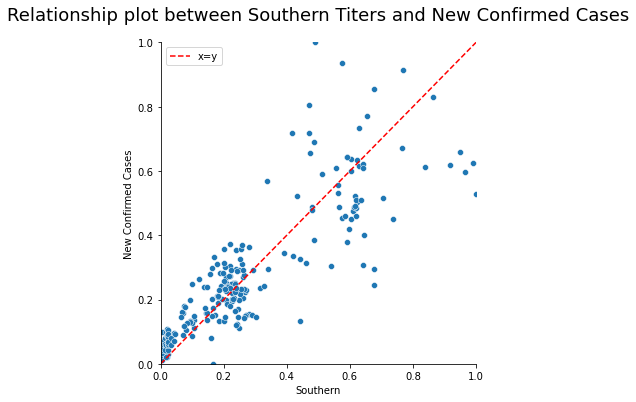

In [157]:
#fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(16,4))
#ax = ax.flatten()

# Show the relation between norther and souther samples
sns.relplot(data=df_aligned, x="Southern", y="New Confirmed Cases")
plt.plot([0,1], [0,1], '--r', label="x=y")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.title('Relationship plot between Southern Titers and New Confirmed Cases', fontsize=18, y=1.05)